In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import copy
import itertools
from utils_graphs import select_significant_areas, create_graph, plot_graph, get_colors, fig_graph_degrees
import utils_PLS as upls
import matplotlib.colors as cm
from matplotlib.lines import Line2D

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'PISA'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA.npy', allow_pickle=True).item()

# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+'_'+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12_noshock']
subjects = list(dict_results_across_mice.keys())


experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels=['noshock','demonstrator', 'observer'])

In [4]:
corr_threshold = 0.75
allen_order = list(volumes[volumes['st_level']==8]['acronym'])

In [5]:
df_levels = upls.create_df_levels(volumes)

# Analysis on relative density

In [6]:
df_noshock_rd, df_demonstrator_rd, df_observer_rd = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='relative_density')


In [7]:
df_ttest_rd = ace.test_across_groups([df_noshock_rd,
                                          df_demonstrator_rd,
                                          df_observer_rd],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'])

df_ttest_not_null_rd = df_ttest_rd.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

sig_areas_rd_ttest = select_significant_areas(df=df_ttest_not_null_rd, 
                                                  threshold=0.05,
                                                 groups=['noshock',
                                               'demonstrator',
                                               'observer'])

corr_matrix_noshock_rd = ace.cross_corr(df_noshock_rd)
corr_matrix_demonstrator_rd = ace.cross_corr(df_demonstrator_rd)
corr_matrix_observer_rd = ace.cross_corr(df_observer_rd)

In [8]:
len(sig_areas_rd_ttest)

31

In [9]:
G_noshock = create_graph(corr_matrix_noshock_rd, volumes=volumes, 
                         significant_areas=sig_areas_rd_ttest, 
                         corr_threshold=corr_threshold, correlations='one')

G_demonstrator = create_graph(corr_matrix_demonstrator_rd,  volumes=volumes, 
                         significant_areas=sig_areas_rd_ttest, 
                         corr_threshold=corr_threshold, correlations='one')

G_observer = create_graph(corr_matrix_observer_rd,  volumes=volumes, 
                         significant_areas=sig_areas_rd_ttest, 
                         corr_threshold=corr_threshold, correlations='one')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


## Graphs of positive correlations

(<Figure size 576x576 with 3 Axes>,
 <AxesSubplot:title={'center':'NO SHOCK'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

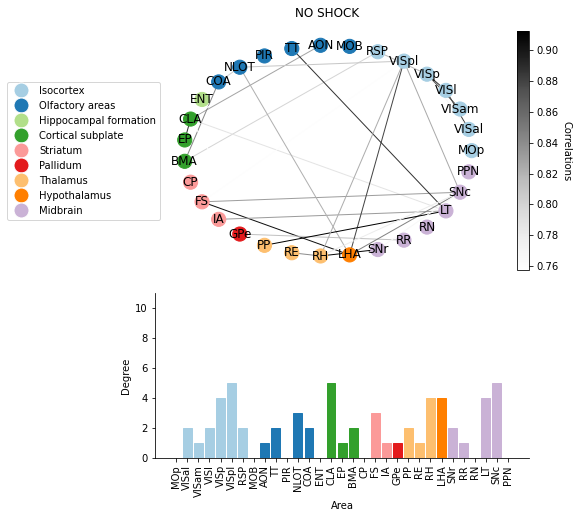

In [10]:
fig_graph_degrees(G=G_noshock, title='NO SHOCK', volumes=volumes, y_lim=11)

(<Figure size 576x576 with 3 Axes>,
 <AxesSubplot:title={'center':'DEMONSTRATOR'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

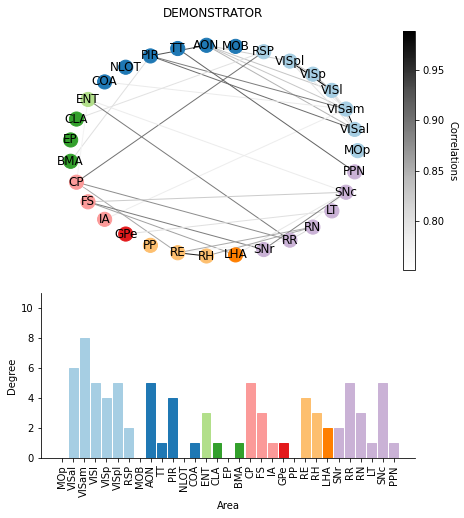

In [11]:
fig_graph_degrees(G=G_demonstrator, title='DEMONSTRATOR', volumes=volumes, show_colorbar=True, show_legend=False, y_lim=11)

(<Figure size 576x576 with 3 Axes>,
 <AxesSubplot:title={'center':'OBSERVER'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

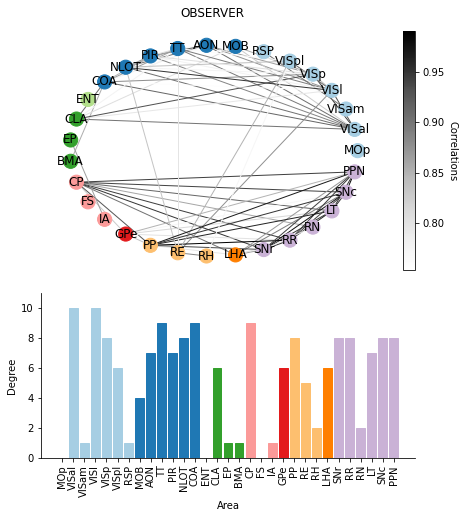

In [12]:
fig_graph_degrees(G=G_observer, title='OBSERVER', volumes=volumes, show_colorbar=True, show_legend=False, y_lim=11)

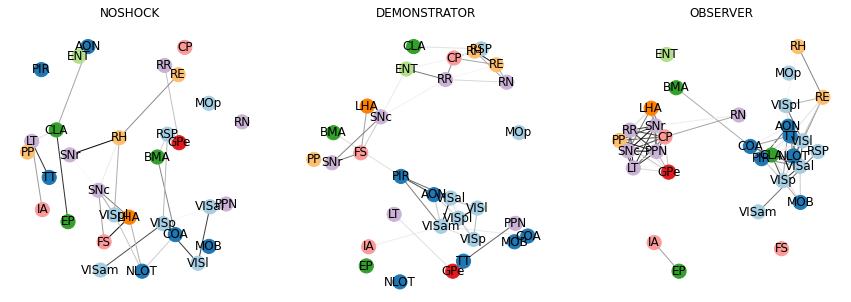

In [13]:
show_colorbar=True
show_legend=True
Gs = [G_noshock, G_demonstrator, G_observer]
titles=['NOSHOCK', 'DEMONSTRATOR', 'OBSERVER']
# create tables
allen_order = list(volumes[volumes['st_level']==8]['acronym'])
df_levels = upls.create_df_levels(volumes)

# create figure
fig = plt.figure(figsize=(15, 5))

edge_cmap = plt.cm.get_cmap('Greys')

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(1, 3)
# plot graph
for i, G in enumerate(Gs):
    ax = fig.add_subplot(axgrid[i])

    order=allen_order

    # Plot the network:
    # pos = nx.spring_layout(sorted(list(G.nodes()),
    #   key = order.index))
    pos = nx.spring_layout(G, k=0.7, seed=42)
    list_colors = get_colors(G, df_levels, order, volumes=volumes)[0]
    nx.draw(G, with_labels=True, node_color=list_colors, 
            node_size=200,font_size=12, pos=pos, ax=ax, edge_cmap=edge_cmap, width=1,
            edge_color=[G[u][v]['weight'] for u, v in G.edges])

    # relabel graphs
    ax.set_title(titles[i])


# Number of cells

In [14]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [15]:
df_ttest_ncells = ace.test_across_groups([df_noshock_ncells,
                                          df_demonstrator_ncells,
                                          df_observer_ncells],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'])

df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

sig_areas_ncells_ttest = select_significant_areas(df=df_ttest_not_null_ncells, 
                                                  threshold=0.05,
                                                 groups=['noshock',
                                               'demonstrator',
                                               'observer'])

corr_matrix_noshock_ncells = ace.cross_corr(df_noshock_ncells)
corr_matrix_demonstrator_ncells = ace.cross_corr(df_demonstrator_ncells)
corr_matrix_observer_ncells = ace.cross_corr(df_observer_ncells)

In [16]:
G_noshock = create_graph(corr_matrix_noshock_ncells, volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')

G_demonstrator = create_graph(corr_matrix_demonstrator_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')

G_observer = create_graph(corr_matrix_observer_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


(<Figure size 576x576 with 3 Axes>,
 <AxesSubplot:title={'center':'NO SHOCK'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

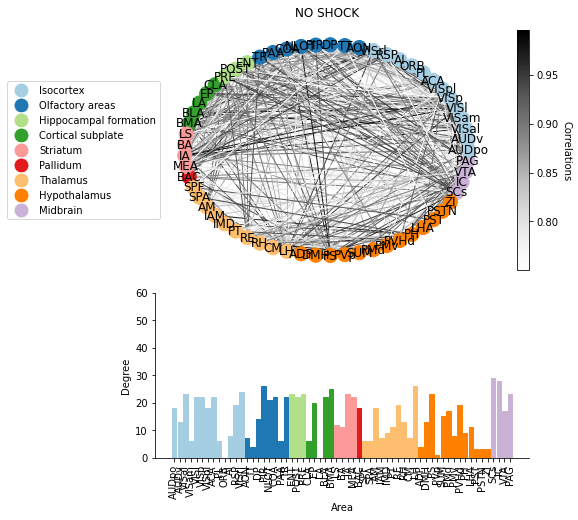

In [17]:
fig_graph_degrees(G=G_noshock, title='NO SHOCK', volumes=volumes, y_lim=60)

(<Figure size 576x576 with 3 Axes>,
 <AxesSubplot:title={'center':'DEMONSTRATOR'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

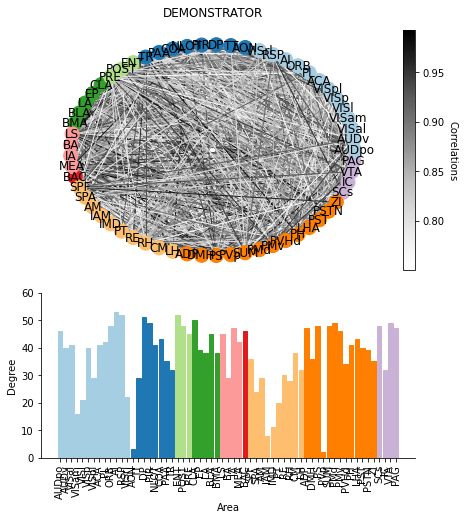

In [18]:
fig_graph_degrees(G=G_demonstrator, title='DEMONSTRATOR', volumes=volumes, show_colorbar=True, show_legend=False, y_lim=60)

(<Figure size 576x576 with 3 Axes>,
 <AxesSubplot:title={'center':'OBSERVER'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

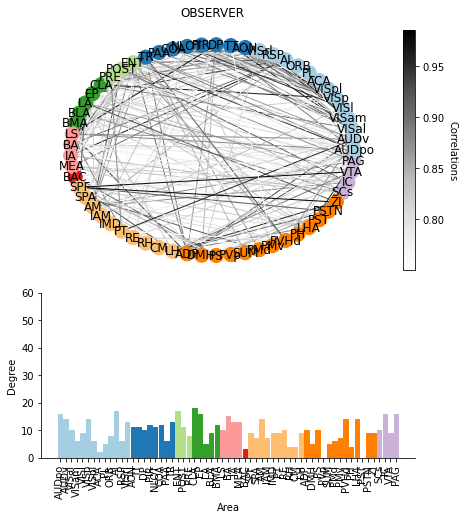

In [19]:
fig_graph_degrees(G=G_observer, title='OBSERVER', volumes=volumes, show_colorbar=True, show_legend=False, y_lim=60)

## Using Spring layout

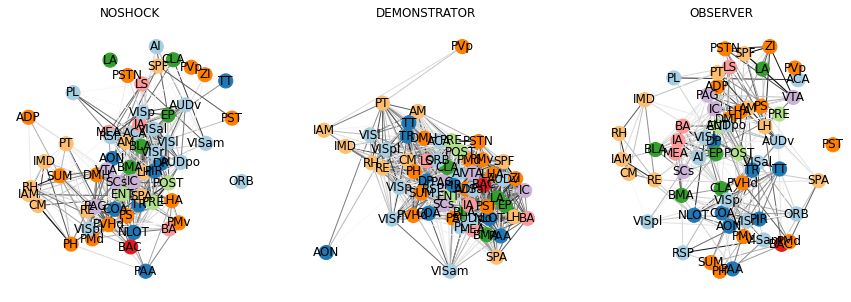

In [20]:
show_colorbar=True
show_legend=True
Gs = [G_noshock, G_demonstrator, G_observer]
titles=['NOSHOCK', 'DEMONSTRATOR', 'OBSERVER']
# create tables
allen_order = list(volumes[volumes['st_level']==8]['acronym'])
df_levels = upls.create_df_levels(volumes)

# create figure
fig = plt.figure(figsize=(15, 5))

edge_cmap = plt.cm.get_cmap('Greys')

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(1, 3)
# plot graph
for i, G in enumerate(Gs):
    ax = fig.add_subplot(axgrid[i])

    order=allen_order

    # Plot the network:
    # pos = nx.spring_layout(sorted(list(G.nodes()),
    #   key = order.index))
    pos = nx.spring_layout(G, k=1.0, seed=42)
    list_colors = get_colors(G, df_levels, order, volumes=volumes)[0]
    nx.draw(G, with_labels=True, node_color=list_colors, 
            node_size=200,font_size=12, pos=pos, ax=ax, edge_cmap=edge_cmap, width=1,
            edge_color=[G[u][v]['weight'] for u, v in G.edges])

    # relabel graphs
    ax.set_title(titles[i])


## Histogram degrees

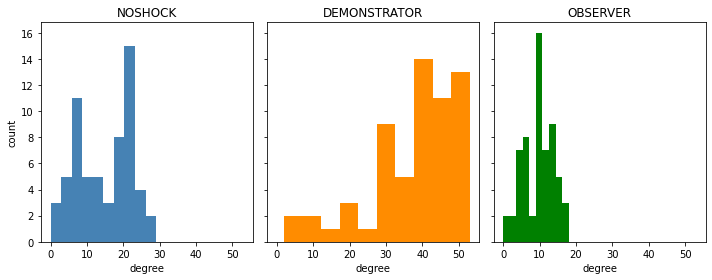

In [21]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axes[0].set_title('NOSHOCK')
axes[0].hist(list(dict(G_noshock.degree).values()),
            color='steelblue')
axes[1].set_title('DEMONSTRATOR')
axes[1].hist(list(dict(G_demonstrator.degree).values()),
            color='darkorange')
axes[2].set_title('OBSERVER')
axes[2].hist(list(dict(G_observer.degree).values()),
            color='green')
for i in range(3):
    axes[i].set_xlabel('degree')
axes[0].set_ylabel('count')
plt.tight_layout()
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree.svg')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree.png')

Text(0, 0.5, 'Degree')

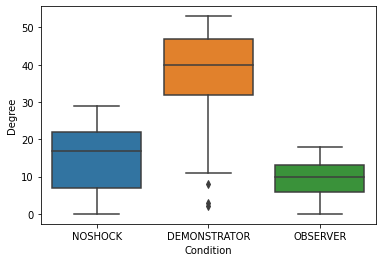

In [22]:
df_boxplot = pd.DataFrame({'NOSHOCK':list(dict(G_noshock.degree).values()), 
                           'DEMONSTRATOR': list(dict(G_demonstrator.degree).values()), 
                           'OBSERVER':list(dict(G_observer.degree).values())})
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_boxplot, ax=ax)
ax.set_xlabel('Condition')
ax.set_ylabel('Degree')

## Histogram weights

## Overall correlations

Text(0.5, 0.98, 'Correlations of all areas')

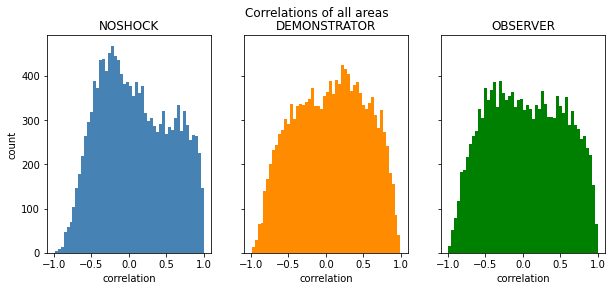

In [23]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
colors = ['steelblue', 'darkorange', 'green']
for i, corr in enumerate([corr_matrix_noshock_rd, 
                          corr_matrix_demonstrator_rd, 
                          corr_matrix_observer_rd]):
    axes[i].hist(corr.mask(np.triu(np.ones(corr.shape)).astype(bool)).stack().values,
            color=colors[i], bins=50)
axes[0].set_title('NOSHOCK')
axes[1].set_title('DEMONSTRATOR')
axes[2].set_title('OBSERVER')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlations of all areas')

## Graphs with nodes identified through PLS

In [24]:
pls_sig_areas = np.load('results_pls/pls_sig_areas_PISA.npy', allow_pickle=True)

In [25]:
G_noshock_pls = create_graph(corr_matrix_noshock_rd, volumes=volumes, 
                         significant_areas=pls_sig_areas, 
                         corr_threshold=0.9, correlations='one')
G_demonstrator_pls = create_graph(corr_matrix_demonstrator_rd,  volumes=volumes, 
                         significant_areas=pls_sig_areas, 
                         corr_threshold=0.9, correlations='one')
G_observer_pls = create_graph(corr_matrix_observer_rd,  volumes=volumes, 
                         significant_areas=pls_sig_areas, 
                         corr_threshold=0.9, correlations='one')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


(<Figure size 576x576 with 3 Axes>,
 <AxesSubplot:title={'center':'NOSHOCK'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

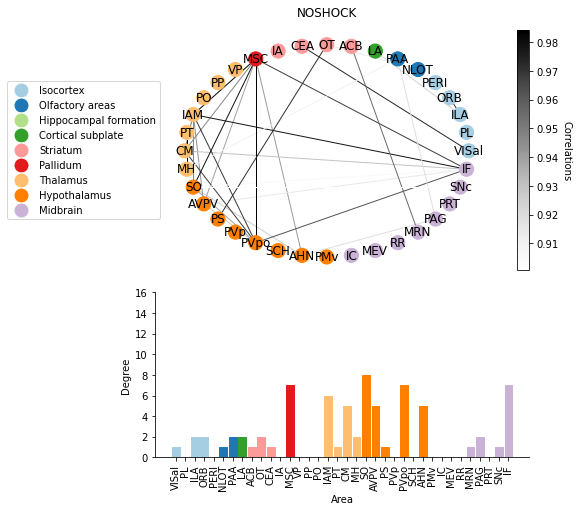

In [26]:
fig_graph_degrees(G=G_noshock_pls, title='NOSHOCK', volumes=volumes)

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'DEMONSTRATOR'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

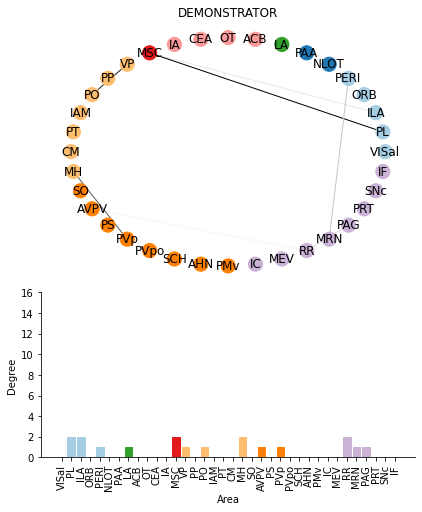

In [27]:
fig_graph_degrees(G=G_demonstrator_pls, title='DEMONSTRATOR', volumes=volumes, show_legend=False, show_colorbar=False)

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'OBSERVER'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

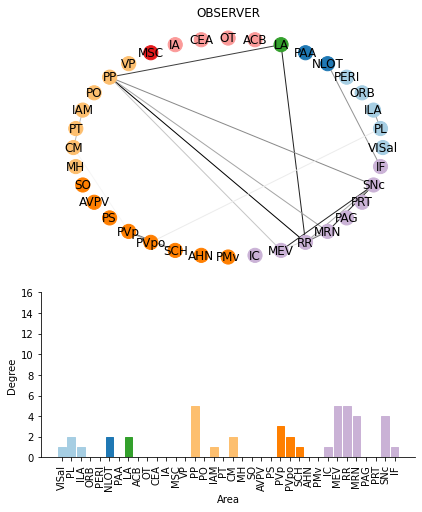

In [28]:
fig_graph_degrees(G=G_observer_pls, title='OBSERVER', volumes=volumes, show_legend=False, show_colorbar=False)